# Counting the Crowds
This notebook demonstrates several approaches to automatic counting of people using images from indoor video cameras in a shopping center.

- **Out-of-the-box solution: EfficientDet** object detection model loaded from **TensorFlow Hub**. The model is capable of detecting a wide range of objects returning predicted class, bounding box coordinates and confidence score for each object. Benefits: doesn't require training, multiple models are available, could be easily deployed on various devices. Drawbacks: model is prone to errors when detecting multiple objects, objects partly accluded or located at the background, model is difficult to retrain and fine-tune.
- **Transfer learning: InceptionResNetV2** as feature extractor with a new regression head. Benefits: model is relatively easy to fine-tune for a new task while retaining the useful knowledge of the original classifier. Drawbacks: despite higher accuracy compared to the previous solution, this model is not perfect and could not be used in environments where high precision is important.

## Part 1: Using out-of-the-box model

**EfficientDet model:** SSD with EfficientNet + BiFPN feature extractor, shared box predictor and focal loss, trained on COCO 2017 dataset. Several models of various sizes could be found at TF Hub. We will use the smallest model d0.

**Model inputs:** a three-channel image of variable size - a tf.uint8 tensor with shape [1, height, width, 3] with values in [0, 255].

#### Algorithm
- Extract example images from .jpg files and convert to tf.Tensor without resizing or preprocessing.
- Visualize model predictions overlaying predicted bounding boxes over the example images.
- Select the minimum confidence score to improve the model accuracy.
- Check the accuracy on randomly selected subset of images:
  - EfficientDet model cannot process batches of images, so we process them one by one using multiprocessing for time optimization.
  - Postprocess the model output for each image counting the number of objects identified as "person" with a selected confidence threshold.

In [2]:
import time
import concurrent.futures
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import PIL
from PIL.ImageDraw import Draw

In [3]:
# Image IDs and target values.
META_FILE = '../input/crowd-counting/labels.csv'

In [4]:
# EfficientDet model
MODEL_PATH = 'https://tfhub.dev/tensorflow/efficientdet/d0/1'

In [5]:
def reconstruct_path(image_id: int) -> str:
    """Function transforms numerical image ID
    into a relative file path filling in leading zeros
    and adding file extension and directory.
    :param image_id: Image ID
    :return: Relative path to the image
    """
    image_id = str(image_id).rjust(6, '0')
    return f'../input/crowd-counting/frames/frames/seq_{image_id}.jpg'


def detect_objects(path: str, model) -> dict:
    """Function extracts image from a file, adds new axis
    and passes the image through object detection model.
    :param path: File path
    :param model: Object detection model
    :return: Model output dictionary
    """
    image_tensor = tf.image.decode_jpeg(
        tf.io.read_file(path), channels=3)[tf.newaxis, ...]
    return model(image_tensor)


def count_persons(path: str, model, threshold=0.) -> int:
    """Function counts the number of persons in an image
    processing "detection_classes" output of the model
    and taking into account confidence threshold.
    :param path: File path
    :param model: Object detection model
    :param threshold: Threshold for confidence scores
    :return: Number of people for one image
    """
    results = detect_objects(path, model)
    # Class ID 1 = "person"
    return (results['detection_classes'].numpy()[0] == 1)[np.where(
        results['detection_scores'].numpy()[0] > threshold)].sum()


def draw_bboxes(image_path, data: dict, threshold=0.) -> PIL.Image:
    """Function displays an image with bounding boxes
    overlaid for every detected person.
    :param image_path: File path to an image
    :param data: Output of objects detection model for this image
    :param threshold: Threshold for confidence scores
    :return: PIL.Image object
    """
    image = PIL.Image.open(image_path)
    draw = Draw(image)

    im_width, im_height = image.size

    boxes = data['detection_boxes'].numpy()[0]
    classes = data['detection_classes'].numpy()[0]
    scores = data['detection_scores'].numpy()[0]

    for i in range(int(data['num_detections'][0])):
        if classes[i] == 1 and scores[i] > threshold:
            ymin, xmin, ymax, xmax = boxes[i]
            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)
            draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
                      width=4, fill='red')

    return image


def set_display():
    """Function sets display options for charts and pd.DataFrames.
    """
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [6]:
set_display()

In [7]:
# Input data
data = pd.read_csv(META_FILE)
data['path'] = data['id'].apply(reconstruct_path)
data.head()

,id,count,path
0,1,35,../input/crowd-counting/frames/frames/seq_0000...
1,2,41,../input/crowd-counting/frames/frames/seq_0000...
2,3,41,../input/crowd-counting/frames/frames/seq_0000...
3,4,44,../input/crowd-counting/frames/frames/seq_0000...
4,5,41,../input/crowd-counting/frames/frames/seq_0000...


In [8]:
stats = data.describe()
stats

,id,count
count,2000.0000,2000.0000
mean,1000.5000,31.1575
std,577.4946,6.9454
min,1.0000,13.0000
25%,500.7500,26.0000
50%,1000.5000,31.0000
75%,1500.2500,36.0000
max,2000.0000,53.0000


Target values (people count) vary between 13 and 53 with a mean of 31.16. Values are normally distributed with the median value close to the mean.

Total number of images is 2,000.

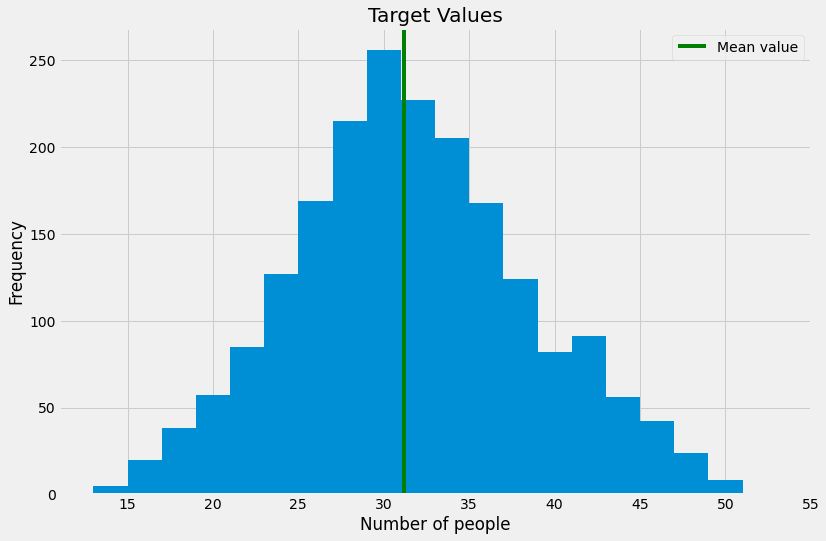

In [9]:
plt.hist(data['count'], bins=20)
plt.axvline(stats.loc['mean', 'count'], label='Mean value', color='green')
plt.legend()
plt.xlabel('Number of people')
plt.ylabel('Frequency')
plt.title('Target Values')
plt.show()

In [10]:
# Load the model.
detector = hub.load(MODEL_PATH)

The output dictionary of the model contains:
- num_detections: a tf.int tensor with only one value, the number of detections [N].
- detection_boxes: a tf.float32 tensor of shape [N, 4] containing bounding box coordinates in the following order: [ymin, xmin, ymax, xmax].
- detection_classes: a tf.int tensor of shape [N] containing detection class index from the label file.
- detection_scores: a tf.float32 tensor of shape [N] containing detection scores.
- raw_detection_boxes: a tf.float32 tensor of shape [1, M, 4] containing decoded detection boxes without Non-Max suppression. M is the number of raw detections.
- raw_detection_scores: a tf.float32 tensor of shape [1, M, 90] and contains class score logits for raw detection boxes. M is the number of raw detections.
- detection_anchor_indices: a tf.float32 tensor of shape [N] and contains the anchor indices of the detections after NMS.
- detection_multiclass_scores: a tf.float32 tensor of shape [1, N, 90] and contains class score distribution (including background) for detection boxes in the image including background class.

We will use "detection_classes" to count the number of persons detected in the image. Index 1 corresponds to "person".

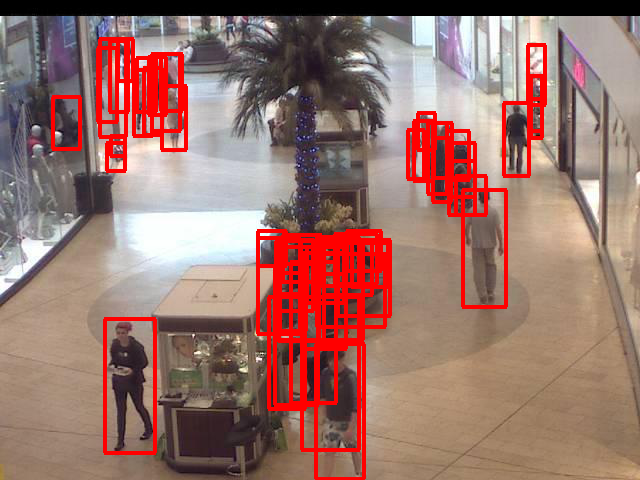

In [14]:
# Object detection with no confidence threshold results in
# duplicate bounding boxes and false positives.
# Total number of people in an image is overestimated.
# Some mannequins are erroneously marked as people.
example_path = '../input/crowd-counting/frames/frames/seq_001900.jpg'
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results)

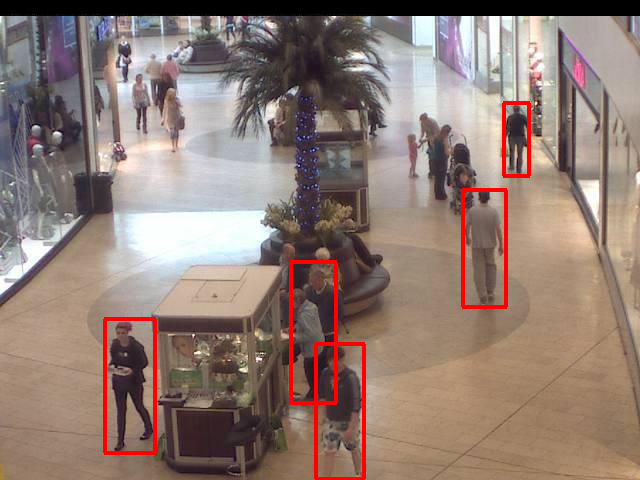

In [15]:
# With high threshold the model underestimates the number of people
# selecting only the most obvious objects at the foreground.
draw_bboxes(example_path, results, threshold=0.5)

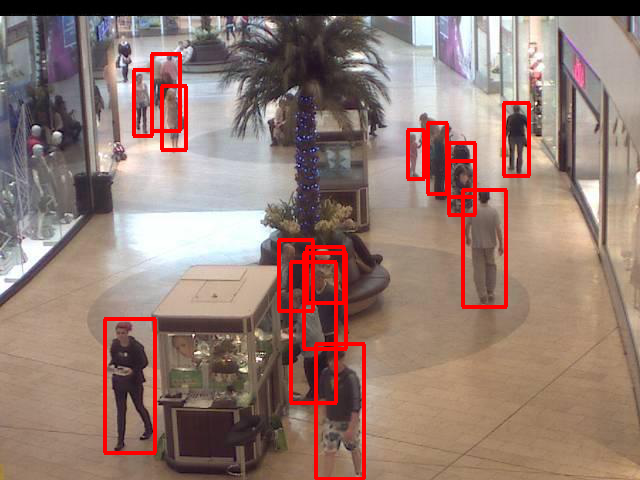

In [16]:
# With relatively low threshold the model is most accurate counting people
# that are located at the foreground and the middle of the picture.
# Objects at the background are mostly ignored.
draw_bboxes(example_path, results, threshold=0.25)

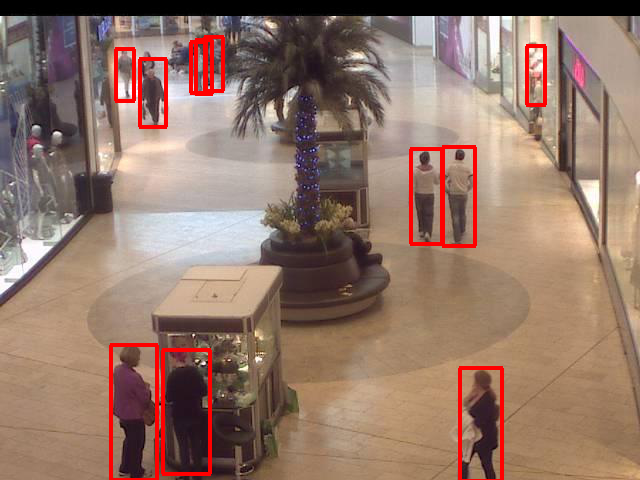

In [17]:
# Test the model on an image with small number of people.
example_path = data.loc[data['count'] == data['count'].min(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

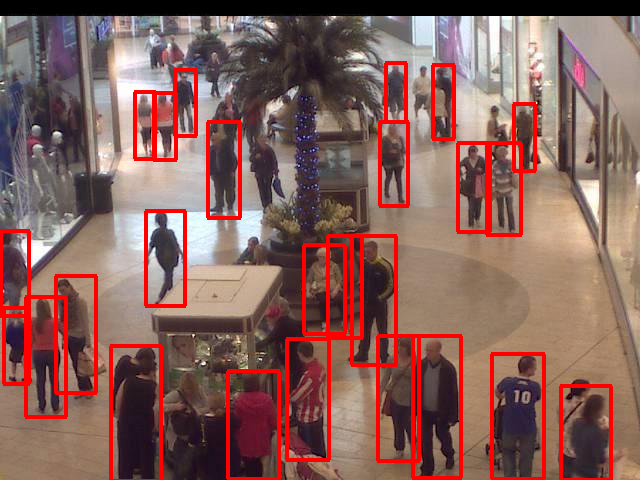

In [18]:
# Test the model on a very crowded image.
example_path = data.loc[data['count'] == data['count'].max(), 'path'].iloc[0]
results = detect_objects(example_path, detector)
draw_bboxes(example_path, results, threshold=0.25)

We can see that the model is not perfect and occasionally drows duplicate bounding boxes or fails to detect a person at the background or in partially occluded areas of the image.

Let's check the model on a randomly selected subset of images using predicted class 1 ("person") with confidence scores above 0.25.

In [19]:
# Performing object detection for 2,000 images takes a considerable time.
# The model processes images one at a time. Batch inference is not available.
# We can speed up the model by using multiprocessing, however it still takes a while.
# For testing purposes we will check the model performance on a randomly selected
# sample of 200 images (10% of the original data set).
sample = data.sample(frac=0.1)
start = time.perf_counter()
objects = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = [executor.submit(count_persons, path, detector, 0.25) for path in sample['path']]
    for f in tqdm(concurrent.futures.as_completed(results)):
        objects.append(f.result())

finish = time.perf_counter()
print(f'Finished in {round(finish - start, 2)} second(s).')

200it [00:22,  9.02it/s]

Finished in 22.26 second(s).


In [20]:
# Compare predicted values with the ground truth.
sample['prediction'] = objects
sample.head(10)

,id,count,path,prediction
87,88,31,../input/crowd-counting/frames/frames/seq_0000...,9
1811,1812,39,../input/crowd-counting/frames/frames/seq_0018...,23
546,547,20,../input/crowd-counting/frames/frames/seq_0005...,20
549,550,25,../input/crowd-counting/frames/frames/seq_0005...,18
815,816,26,../input/crowd-counting/frames/frames/seq_0008...,16
665,666,20,../input/crowd-counting/frames/frames/seq_0006...,21
1498,1499,24,../input/crowd-counting/frames/frames/seq_0014...,15
1162,1163,34,../input/crowd-counting/frames/frames/seq_0011...,21
1658,1659,46,../input/crowd-counting/frames/frames/seq_0016...,18
499,500,29,../input/crowd-counting/frames/frames/seq_0005...,22


MAE = 12.22
MSE = 200.43


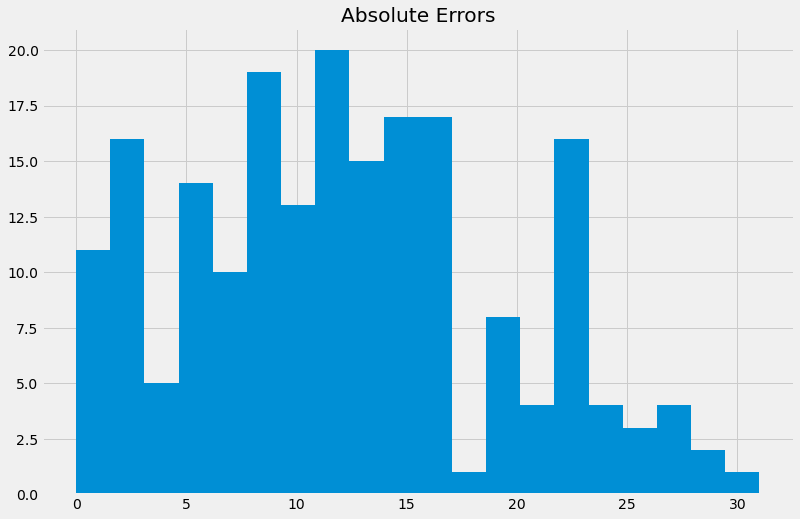

In [21]:
sample['mae'] = (sample['count'] - sample['prediction']).abs()
sample['mse'] = sample['mae'] ** 2

print(f'MAE = {sample["mae"].mean()}\nMSE = {sample["mse"].mean()}')
plt.hist(sample['mae'], bins=20)
plt.title('Absolute Errors')
plt.show()

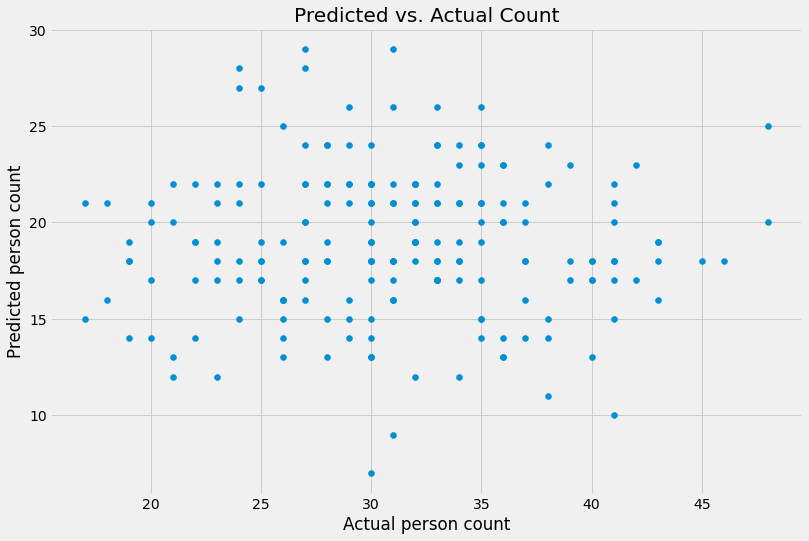

In [22]:
plt.scatter(sample['count'], sample['prediction'])
plt.xlabel('Actual person count')
plt.ylabel('Predicted person count')
plt.title('Predicted vs. Actual Count')
plt.show()

We can conclude that out-of-the-box solution cannot be used for this task. The model is good at detecting objects at the foreground and middle of the image and fails at "counting" numerous objects of the same class located all over the image. Despite the attempts to improve performance with confidence scores, the eror rate is high.

## Part 2: Transfer learning

We will load **InceptionResNetV2 model** from **Keras** applications and freeze the original weights. The model will be trained with a new regression head. The learning rate will be adjusted whenever validation loss is getting worse.

The original model was trained on images of size 299 x 299. We will resize the images accordingly using padding to avoid distorting the objects. To compensate for small number of training samples we will apply various image augmentation techniques randomly changing brightness, contract, saturation and hue and flipping the images left-to-right.

In [23]:
import os
import random

In [24]:
# TensorFlow settings and training parameters
AUTOTUNE = tf.data.experimental.AUTOTUNE
EPOCHS = 500
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 1e-3
IMAGE_SIZE = 299

In [25]:
def load_image(is_labelled: bool, is_training=True):
    """Wrapper function that returns a function
    for loading a single image if is_labelled=False
    or a function for loading image in an image-label pair
    if is_labelled=True.
    :param is_labelled: Boolean argument defining the return
    :param is_training: Boolean argument for image augmentation
    :return: Function
    """
    def _get_image(path: str) -> tf.Tensor:
        """Function loads image from a file.
        :param path: Path to image file
        :return: Tensor with preprocessed image
        """
        image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        image = tf.cast(image, dtype=tf.int32)
        image = tf.image.resize_with_pad(image, IMAGE_SIZE, IMAGE_SIZE)
        if is_training:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, 0.1)
            image = tf.image.random_contrast(image, 0.1, 0.2)
            image = tf.image.random_saturation(image, 0.9, 1.1)
            image = tf.image.random_hue(image, 0.1)
        return tf.keras.applications.inception_resnet_v2.preprocess_input(image)

    def _get_image_label(img: tf.Tensor, label: int) -> tuple:
        """Function loads the image in an image-label pair.
        :param img: Tensor with original image
        :param label: Target value
        :return: Tuple with TF tensor and label
        """
        return _get_image(img), label

    return _get_image_label if is_labelled else _get_image


def prepare_dataset(dataset, is_training=True, is_labeled=True):
    """Function transforms a TF dataset containing file paths
    or file paths and labels to a dataset with image tensors and labels.
    :param dataset: Original dataset
    :param is_training: Argument defines if shuffling and image augmentation should be applied
    :param is_labeled: Argument defines if the dataset contains labels
    :return: Updated dataset
    """
    image_read_fn = load_image(is_labeled, is_training)
    dataset = dataset.map(image_read_fn, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)


def create_model() -> tf.keras.Model:
    """Function initializes and compiles a regression model
    with pretrained feature extractor.
    :return: TF Model object
    """
    feature_model = tf.keras.applications.InceptionResNetV2(
        include_top=False, pooling='avg')
    feature_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        feature_model,
        tf.keras.layers.Dense(512, activation='selu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    return model


def plot_history(hist):
    """Function plots a chart with training and validation metrics.
    :param hist: Tensorflow history object from model.fit()
    """
    mae = hist.history['mean_absolute_error']
    val_mae = hist.history['val_mean_absolute_error']
    x_axis = range(1, len(mae) + 1)
    plt.plot(x_axis, mae, 'bo', label='Training')
    plt.plot(x_axis, val_mae, 'ro', label='Validation')
    plt.title('MAE')
    plt.legend()
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()


def set_seed(seed=42):
    """Utility function to use for reproducibility.
    :param seed: Random seed
    :return: None
    """
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [26]:
set_seed()

In [27]:
# Create train and validation data sets.
data_train = data.head(1700)
data_valid = data.tail(300)

ds_train = tf.data.Dataset.from_tensor_slices((data_train['path'], data_train['count']))
ds_valid = tf.data.Dataset.from_tensor_slices((data_valid['path'], data_valid['count']))

ds_train = prepare_dataset(ds_train)
ds_valid = prepare_dataset(ds_valid, is_training=False)

In [28]:
# Load the model.
model = create_model()

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=PATIENCE,
    restore_best_weights=True)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', patience=1, cooldown=1, verbose=1,
    factor=0.75, min_lr=1e-8)

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=EPOCHS, callbacks=[early_stop, lr_reduction],
                    use_multiprocessing=True, workers=os.cpu_count())

219070464/219055592 [==============================] - 6s 0us/step
Epoch 1/500
107/107 [==============================] - 28s 162ms/step - loss: 67.2462 - mean_absolute_error: 6.4535 - val_loss: 47.8028 - val_mean_absolute_error: 6.0515
Epoch 2/500
107/107 [==============================] - 14s 126ms/step - loss: 44.6639 - mean_absolute_error: 5.4073 - val_loss: 42.8547 - val_mean_absolute_error: 5.7650
Epoch 3/500
107/107 [==============================] - 14s 127ms/step - loss: 40.2910 - mean_absolute_error: 5.1172 - val_loss: 48.3016 - val_mean_absolute_error: 6.1545

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Epoch 4/500
107/107 [==============================] - 14s 126ms/step - loss: 39.1759 - mean_absolute_error: 4.8804 - val_loss: 31.5051 - val_mean_absolute_error: 4.9264
Epoch 5/500
107/107 [==============================] - 14s 126ms/step - loss: 34.1253 - mean_absolute_error: 4.5609 - val_loss: 31.1904 - val_mean_absolute_error: 4.9074
Ep

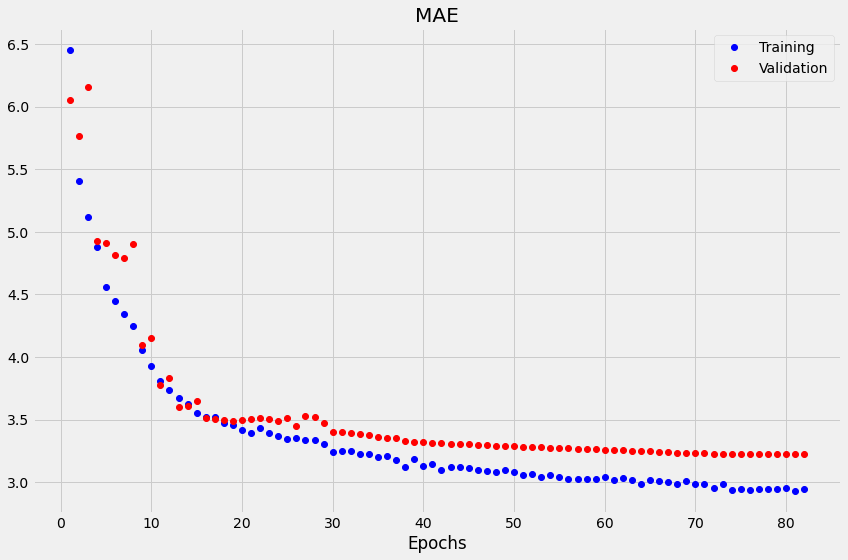

In [29]:
plot_history(history)

In [30]:
mse, mae = model.evaluate(ds_valid)
print(f'Validation MSE = {mse}\n'
      f'Validation MAE = {mae}')

19/19 [==============================] - 2s 106ms/step - loss: 16.8865 - mean_absolute_error: 3.2268
Validation MSE = 16.88646697998047
Validation MAE = 3.226757764816284


In [31]:
model.save('model.h5')